# Looking for outliers in the latent space

In GAN architecture encoder learns to map input to the latent space. This notebook shows an example of how to detect outliers from the target gaussian mixture distribution.

---

## Load model and predict

In [11]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from math import sin, cos
from scipy.stats import norm

Model parameters and utility objects

In [12]:
from utils.prior_utils import PriorFactory
from utils.plot_utils import PlotFactory
from utils.data_loader import DataLoader

n_classes = 10
result_dir = 'results'
prior_type = 'gaussian_mixture'
prior_factory = PriorFactory(n_classes)

gm_x_stddev = prior_factory.gaussian_mixture_x_stddev
gm_y_stddev = prior_factory.gaussian_mixture_y_stddev

batch_size = 128
data_loader = DataLoader(batch_size)

plot_factory = PlotFactory(prior_factory, result_dir, prior_type, n_classes, 
                           data_loader.img_size_x, data_loader.img_size_y)

Load saved weights

In [13]:
encoder = tf.saved_model.load("data/encoder_model") # Modify path or use this example
decoder = tf.saved_model.load("data/decoder_model") # Modify path or use this example
discriminator = tf.saved_model.load("data/discriminator_model") # Modify path or use this example

from model.aae import Gan, Encoder, Discriminator
gan = Gan(image_dim=data_loader.img_size_x * data_loader.img_size_y)

# use restored models
gan.encoder = encoder
gan.decoder = decoder
gan.discriminator = discriminator

Prepare test data

In [14]:
n_tot_imgs = n_classes * n_classes
n_tot_imgs_sampled = plot_factory.x_sampling_reconstr * plot_factory.y_sampling_reconstr
dist_sample_count = 10000

# Distribution demo
plot_factory.plot_distribution_demo(prior_type, dist_sample_count)

# Test data for distribution plot
_, _ = data_loader.make_dataset()
x_test, labels_test = data_loader.get_test_sample(dist_sample_count, dist_sample_count)

Predict

In [15]:
z = gan.encoder(x_test, training=False)
z = z.numpy()

## Find outliers

Pick a label to find outliers for

In [16]:
label_explain = 3 # Modify label index 

Rotate and shif to the oryginal position of the target distribution

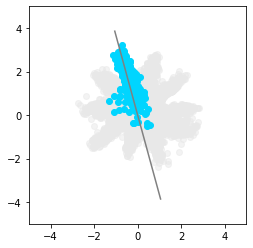

In [17]:
# Indices for label explain
label_explain_indx = [i for i, x in enumerate(labels_test) if np.argmax(x)==label_explain]
z_explain = z[label_explain_indx]

# Perform PCA to find real (learnt) angle (expected label*2pi/n_classes)
x = [elem[0] for elem in z[label_explain_indx]]
y = [elem[1] for elem in z[label_explain_indx]]
x_0 = x - np.mean(z_explain[:, 0])
y_0 = y - np.mean(z_explain[:, 1])
coords = np.array([x_0, y_0])
eigen_vals, eigen_vecs = np.linalg.eig(np.cov(coords))
# Eigenvector with largest eigen value
sort_indices = np.argsort(eigen_vals)[::-1]
eigen_vec_1_x, eigen_vec_1_y = eigen_vecs[:, sort_indices[0]] 


# Plot
COL_GREY = (232/255., 232/255., 232/255., 0.5)
cmap=plt.cm.get_cmap('jet', n_classes)
    
def plot_label():
    plt.scatter(z[:, 0], z[:, 1], color=COL_GREY)
    plt.scatter(z_explain[:, 0], z_explain[:, 1], color=cmap(label_explain), 
                label='Label '+str(label_explain))
    
    axes = plt.gca()
    axes_max = int(3.5*3*gm_x_stddev)
    axes.set(xlim=(-axes_max, axes_max), ylim=(-axes_max, axes_max))
    axes.set_aspect('equal')
    
def plot_main_direction():
    plot_label()
    
    # Main direction (direction of the first eigen vector)
    plt.plot([eigen_vec_1_x*-4, eigen_vec_1_x*4],
                [eigen_vec_1_y*-4, eigen_vec_1_y*4], color='grey')

plot_main_direction()    
plt.show()
plt.close()

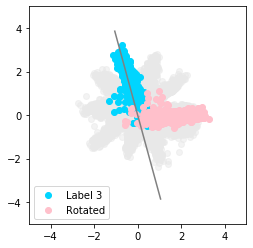

In [18]:
def rotate_angle(points, angle):
    '''Rotates points with give coordinates by angle'''
    rotation_matrix = np.array([[cos(angle), -sin(angle)], [sin(angle), cos(angle)]])
    return np.array([rotation_matrix.dot(point) for point in points])

# Rotation angle (using axis corresponding to the 1st eigen value: length)
distribution_base_vec = [1, 0]
rotation_vec = [abs(eigen_vec_1_x), abs(eigen_vec_1_y)]
cos_angle = np.dot(distribution_base_vec, rotation_vec) / \
(np.linalg.norm(distribution_base_vec) * np.linalg.norm(rotation_vec))
angle = np.arccos(cos_angle)
angle = -np.sign(np.mean(y))*angle if np.sign(np.mean(x))>=0 \
        else -np.sign(np.mean(y))*(np.pi-angle)

z_explain_rotated = rotate_angle(z_explain, angle)


# Plot
import matplotlib.markers as mmark
    
def plot_rotated():   
    plt.scatter(z_explain_rotated[:, 0], z_explain_rotated[:, 1], color='pink', label = 'Rotated')
       
plot_main_direction()
plot_rotated()
plt.legend(loc=3)
plt.show()
plt.close()

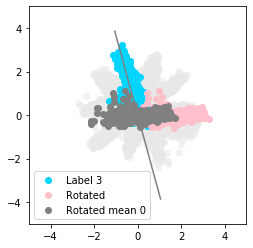

In [19]:
# Find value of a shift necessary to bring rotated learnt distribution go 0 mean 
x_dist = norm.fit(z_explain_rotated[:, 0])
y_dist = norm.fit(z_explain_rotated[:, 1])
density_xy = np.array([[norm.pdf(x[0], x_dist[0], x_dist[1]), 
                        norm.pdf(x[1], y_dist[0], y_dist[1])] 
                       for x in z_explain_rotated])

# Central point - high density along x and y
density_x = [norm.pdf(x, x_dist[0], x_dist[1]) for x in z_explain_rotated[:, 0]]
density_y = [norm.pdf(x, y_dist[0], y_dist[1]) for x in z_explain_rotated[:, 1]]
max_density_point = sorted([x for x in enumerate(zip(density_x, density_y))], 
       key=lambda x: x[1][0]*x[1][1])[-1]

# Shift to 0 mean along both axes
z_explain_rotated_shifted = np.column_stack(
    ([z_explain_rotated[:,0] - z_explain_rotated[max_density_point[0], :][0], 
      z_explain_rotated[:,1] - z_explain_rotated[max_density_point[0], :][1]]))


# Plot
plot_main_direction()
plot_rotated()
    
def plot_rotated_shifted():
    plt.scatter(z_explain_rotated_shifted[:, 0], z_explain_rotated_shifted[:, 1], 
                color='grey', label='Rotated mean 0')
    
plot_rotated_shifted()
plt.legend(loc=3)
plt.show()
plt.close()

Outliers

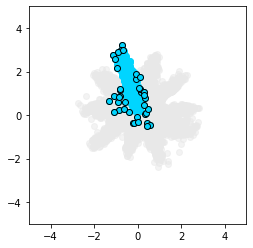

In [20]:
# Assumed distribution
x_dist_assumed = (0, prior_factory.gaussian_mixture_x_stddev)
y_dist_assumed = (0, prior_factory.gaussian_mixture_y_stddev)

# Test with other values of epsilon
epsilon = 0.01 #0.5 

# Find points with low values of probability density function for the target distributions along x and y
density_assumed = np.array([[norm.pdf(x[0], 0, x_dist_assumed[1]), norm.pdf(x[1], 0, y_dist_assumed[1])] 
                        for x in z_explain_rotated_shifted])
outliers_row_id = [row_id for row_id, row in enumerate(density_assumed) 
                   if (row[0]<epsilon or row[1]<epsilon)]


# Plot
plot_label()
plt.scatter(z_explain[outliers_row_id, 0], z_explain[outliers_row_id, 1], 
            color=cmap(label_explain), edgecolors='black')

plt.show()
plt.close()